### Interpret Results

In [15]:
# Run this script to add the src directory to the python path

from notebook_utils import modify_sys_path, get_src_dir_path

modify_sys_path()

In [34]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import re
from csaps import csaps

from src.utils import calculate_min_Va_by_KL_threshold, calculate_min_Va_by_KL_rank

In [41]:
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "text.latex.preamble": r"\usepackage{amsmath}"
})

In [17]:
# results_directory = 'results/logistic_regression_3/experiment_2/active_learning/dataset_specified/'

results_directory = 'results/logistic_regression_3/experiment_2_14b_seed_change/'

In [18]:
shots = 15

In [19]:
# Load the results
df_list = []
for filename in os.listdir(get_src_dir_path(results_directory)):
    if f"results_{shots}_shot" in filename:
        save_data = pd.read_csv(get_src_dir_path(results_directory) + filename)
        df_list.append(save_data)

In [20]:
D_data = None

for filename in os.listdir(get_src_dir_path(results_directory)):
    if f"D_{shots}" in filename:
        D_data = pd.read_csv(get_src_dir_path(results_directory) + filename)

In [21]:
feature_column = [col for col in D_data.columns if col != 'label' and col != 'note'][0]


In [22]:
for save_data in df_list:
    # z_data = calculate_min_Va_by_KL_threshold(z_data, threshold=0.005, forward_kl=True)
    save_data = calculate_min_Va_by_KL_rank(save_data, num_valid_Va=5, forward_kl=True)

In [23]:

PROB_LABELS = ["0", "1"]

x_x1_list = []
total_uncertainty_list = []
kl_pyx_pyxz_list = []
kl_pyxz_pyx_list = []
min_Va_list = []    
max_Ve_list = []
z_value_for_min_Va_list = []

prob_y_xz_list = []
prob_y_x_list = []
within_threshold_list = []


for z_df in df_list:
    try:
        x_x1 = z_df[f'x_{feature_column}'].values[0]
        x_x1_list.append(x_x1)
        total_uncertainty = z_df["H[p(y|x,D)]"].values[0]
        total_uncertainty_list.append(total_uncertainty)
        prob_y_xz = {}
        prob_y_x = {}
        # index where z_value_for_min_Va is True
        min_Va_index = z_df[z_df["z_value_for_min_Va"]].index[0]
        z_value_for_min_Va_list.append(z_df[f"z_{feature_column}"].values[min_Va_index])
        for label in PROB_LABELS:
            prob_y_xz[label] = z_df[f"p(y={label}|x,z,D)"].values[min_Va_index]
            prob_y_x[label] = z_df[f"p(y={label}|x,D)"].values[min_Va_index]
        prob_y_xz_list.append(prob_y_xz)
        prob_y_x_list.append(prob_y_x)
        kl_pyx_pyxz = z_df["kl_pyx_pyxz"].values[min_Va_index]
        kl_pyx_pyxz_list.append(kl_pyx_pyxz)
        kl_pyxz_pyx = z_df["kl_pyxz_pyx"].values[min_Va_index]
        kl_pyxz_pyx_list.append(kl_pyxz_pyx)
        min_Va = z_df["min_Va"].values[0]
        min_Va_list.append(min_Va)
        max_Ve = z_df["max_Ve"].values[0]
        max_Ve_list.append(max_Ve)
        
        within_threshold_list.append(z_df[z_df["within_threshold"]][f"z_{feature_column}"].values)
        
    except:
        pass
    
# Create a dataframe from the lists
data = {f'x_{feature_column}': x_x1_list,
        'total_uncertainty': total_uncertainty_list,
        'min_Va': min_Va_list,
        'max_Ve': max_Ve_list,
        'kl_pyx_pyxz': kl_pyx_pyxz_list,
        'kl_pyxz_pyx': kl_pyxz_pyx_list,
        'z_value_for_min_Va': z_value_for_min_Va_list,
        'within_threshold': within_threshold_list
        }

for label in PROB_LABELS:
    data[f"p(y={label}|x,z,D)"] = [d[label] for d in prob_y_xz_list]
    data[f"p(y={label}|x,D)"] = [d[label] for d in prob_y_x_list]

num_Va = len(min_Va_list)

# reduce the length of list to the number of num_Va
for key in data.keys():
    data[key] = data[key][:num_Va]

shots_df = pd.DataFrame(data)

shots_df = shots_df.sort_values(by='x_x1')


In [42]:
# plot x vs total uncertainty and min Va

plt.figure(figsize=(10, 6))
plt.scatter(shots_df[f'x_{feature_column}'], shots_df['total_uncertainty'], label='Total Uncertainty', alpha=0.5)
plt.scatter(shots_df[f'x_{feature_column}'], shots_df['min_Va'], label='Aleatoric Uncertainty', alpha=0.5)

# vertical line for the true x
label_0_seen = False
label_1_seen = False
for i, row in D_data.iterrows():
    if row['label'] == 0:
        if not label_0_seen:
            label_0_seen = True
            label_string = 'ICL example y=0'
        else:
            label_string = None
        plt.axvline(x=row[feature_column], color='r', linestyle='--', alpha=0.4, label=label_string)
    else:
        if not label_1_seen:
            label_1_seen = True
            label_string = 'ICL example y=1'
        else:
            label_string = None
        plt.axvline(x=row[feature_column], color='b', linestyle='--', alpha=0.4, label=label_string)
# plt.title(f"Total Uncertainty and min Va for {shots} shots")

x_grid = np.linspace(shots_df[f'x_{feature_column}'].min(), shots_df[f'x_{feature_column}'].max(), 100)
y_total_uncertainty = csaps(shots_df[f'x_{feature_column}'], shots_df['total_uncertainty'], smooth=0.85)
y_min_Va = csaps(shots_df[f'x_{feature_column}'], shots_df['min_Va'], smooth=0.85)

plt.plot(x_grid, y_total_uncertainty(x_grid), color='blue')
plt.plot(x_grid, y_min_Va(x_grid), color='orange')
# plt.yscale('log')
plt.xlabel('x')
plt.ylabel('Uncertainty')
plt.legend()

plt.tight_layout()

plt.show()

RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmp6tlte34e 809888942d588674f86b8c0caf74ce7a70a4f4655b4edc1e75a4fa3720786a06.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live 2022/dev/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./809888942d588674f86b8c0caf74ce7a70a4f4655b4edc1e75a4fa3720786a06.tex
LaTeX2e <2021-11-15> patch level 1
L3 programming layer <2022-01-21>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)

! LaTeX Error: File `type1ec.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.8 \usepackage
               [utf8]{inputenc}^^M
No pages of output.
Transcript written on tmp6tlte34e/809888942d588674f86b8c0caf74ce7a70a4f4655b4ed
c1e75a4fa3720786a06.log.




Error in callback <function _draw_all_if_interactive at 0x7dac0918f7f0> (for post_execute), with arguments args (),kwargs {}:


RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmp79_lr5vk 809888942d588674f86b8c0caf74ce7a70a4f4655b4edc1e75a4fa3720786a06.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live 2022/dev/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./809888942d588674f86b8c0caf74ce7a70a4f4655b4edc1e75a4fa3720786a06.tex
LaTeX2e <2021-11-15> patch level 1
L3 programming layer <2022-01-21>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)

! LaTeX Error: File `type1ec.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.8 \usepackage
               [utf8]{inputenc}^^M
No pages of output.
Transcript written on tmp79_lr5vk/809888942d588674f86b8c0caf74ce7a70a4f4655b4ed
c1e75a4fa3720786a06.log.




RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmp8o6swwyx 809888942d588674f86b8c0caf74ce7a70a4f4655b4edc1e75a4fa3720786a06.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live 2022/dev/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./809888942d588674f86b8c0caf74ce7a70a4f4655b4edc1e75a4fa3720786a06.tex
LaTeX2e <2021-11-15> patch level 1
L3 programming layer <2022-01-21>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)

! LaTeX Error: File `type1ec.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.8 \usepackage
               [utf8]{inputenc}^^M
No pages of output.
Transcript written on tmp8o6swwyx/809888942d588674f86b8c0caf74ce7a70a4f4655b4ed
c1e75a4fa3720786a06.log.




<Figure size 1000x600 with 1 Axes>

In [ ]:
plt.figure()
plt.plot([0, 1], [0, 1])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'$y = x$')  # math rendered, but no LaTeX backend needed
plt.show()

RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpd71ql_3n 809888942d588674f86b8c0caf74ce7a70a4f4655b4edc1e75a4fa3720786a06.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live 2022/dev/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./809888942d588674f86b8c0caf74ce7a70a4f4655b4edc1e75a4fa3720786a06.tex
LaTeX2e <2021-11-15> patch level 1
L3 programming layer <2022-01-21>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)

! LaTeX Error: File `type1ec.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.8 \usepackage
               [utf8]{inputenc}^^M
No pages of output.
Transcript written on tmpd71ql_3n/809888942d588674f86b8c0caf74ce7a70a4f4655b4ed
c1e75a4fa3720786a06.log.




<Figure size 640x480 with 1 Axes>

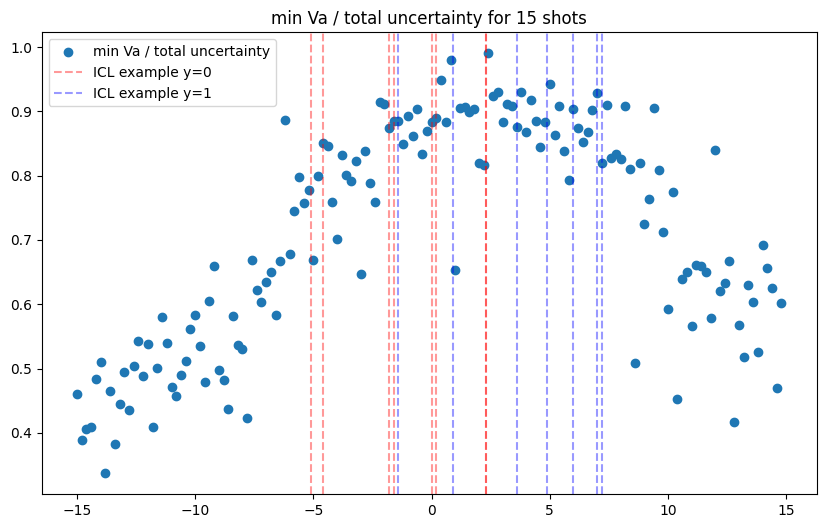

In [11]:
# min Va total uncertainty ratio

shots_df['min_Va_total_uncertainty_ratio'] = shots_df['min_Va'] / shots_df['total_uncertainty']

plt.figure(figsize=(10, 6))
plt.scatter(shots_df['x_x1'], shots_df['min_Va_total_uncertainty_ratio'], label='min Va / total uncertainty')

# vertical line for the true x
label_0_seen = False
label_1_seen = False
for i, row in D_data.iterrows():
    if row['label'] == 0:
        if not label_0_seen:
            label_0_seen = True
            label_string = 'ICL example y=0'
        else:
            label_string = None
        plt.axvline(x=row['x1'], color='r', linestyle='--', alpha=0.4, label=label_string)
    else:
        if not label_1_seen:
            label_1_seen = True
            label_string = 'ICL example y=1'
        else:
            label_string = None
        plt.axvline(x=row['x1'], color='b', linestyle='--', alpha=0.4, label=label_string)
plt.title(f"min Va / total uncertainty for {shots} shots")

# plt.yscale('log')
plt.legend()
plt.show()

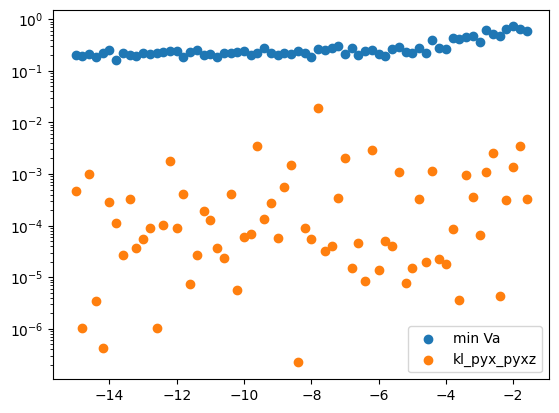

In [11]:
# plot x vs the kl divergence

plt.figure()
plt.scatter(shots_df['x_x1'], shots_df['min_Va'], label='min Va')
plt.scatter(shots_df['x_x1'], shots_df['kl_pyx_pyxz'], label='kl_pyx_pyxz')
plt.yscale('log')
plt.legend()
plt.show()


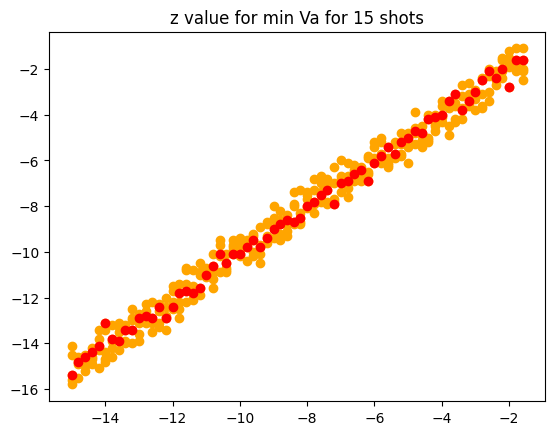

In [12]:
# plot x vs z_value_for_min_Va and within_threshold_values


plt.figure()
for i, row in shots_df.iterrows():
    x = row["x_x1"]
    within_threshold = row["within_threshold"]
    for value in within_threshold:
        plt.scatter(x, value, c='orange')
plt.scatter(shots_df['x_x1'], shots_df['z_value_for_min_Va'], c='r', label='z_value_for_min_Va')
plt.title(f"z value for min Va for {shots} shots")
plt.show()